<a href="https://colab.research.google.com/github/hamsungmin/DataTrainAnalysis/blob/main/project_week8_GPT%ED%99%9C%EC%9A%A9_%EA%B3%A0%EA%B0%9D%ED%94%BC%EB%93%9C%EB%B0%B1%EB%B6%84%EC%84%9D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#############################################
## gpt API를 이용한 텍스트 생성 및 증강
##############################################
from google.colab import userdata
from openai import OpenAI

# API 설정
client = OpenAI(api_key=userdata.get('open_api'))

# GPT에 요청할 프롬프트
prompt = """
100개의 고객 피드백 데이터를 생성해주세요.
조건:
1. 긍정(1)과 부정(0)을 섞어주세요.
2. 출력 형식: CSV로 바로 변환 가능하게 "feedback","label" 형태로.
3. 라벨: 긍정=1, 부정=0
4. 피드백 길이는 10~30자 정도로 다양하게
5. 한글로 작성
6. 출력 예시:
"정말 좋은 제품이에요!",1
"배송이 너무 늦어요.",0
7. 헤더값이 될수 있게 첫라인은 "feedback", "label" 로 해줘
"""

response = client.chat.completions.create(
    model="gpt-4",
    messages=[
        {"role": "system", "content": "당신은 고객 피드백 생성 전문가입니다."},
        {"role": "user", "content": prompt}
    ],
    temperature=0.7,
    max_tokens=2000
)

# GPT 응답
csv_text = response.choices[0].message.content.strip()

# CSV로 저장
with open("customer_feedback_gpt.csv", "w", encoding="utf-8-sig") as f:
    f.write(csv_text)

print("customer_feedback_gpt.csv 파일이 생성되었습니다.")

customer_feedback_gpt.csv 파일이 생성되었습니다.


In [ ]:
import pandas as pd
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt

- **데이터 불러오기 및 결측치 확인**
    - `customer_feedback.csv` 파일을 Pandas를 사용해 읽어옵니다.
    - 각 열에 존재하는 NaN(결측치) 개수를 확인합니다.

In [ ]:
# customer_feedback.csv 파일을 Pandas를 사용해 읽어옵니다.
df = pd.read_csv('/content/customer_feedback_gpt.csv')

In [ ]:
# 각 열에 존재하는 NaN(결측치) 개수를 확인합니다
missing_values = df.isna().sum()
print("=== 결측치 확인 ===")
print(missing_values)

print("=== 발견된 결측치 확인 ===")
print(df[df.isna().any(axis=1)]) # 실제 NaN이 포함된 행 보기

df = df.dropna(subset=['label']) # NaN 결측치 부분 행 제거

re_missing_values = df.isna().sum()
print("=== 결측치 재확인 ===")
print(re_missing_values)

=== 결측치 확인 ===
feedback    0
label       0
dtype: int64
=== 발견된 결측치 확인 ===
Empty DataFrame
Columns: [feedback, label]
Index: []
=== 결측치 재확인 ===
feedback    0
label       0
dtype: int64


- **긍정/부정 라벨 분포 확인**
    - 각 라벨(긍정=1, 부정=0)별 샘플 수를 계산
    - 전체 데이터에서 차지하는 비율도 함께 계산해 데이터 편향 여부를 확인

In [ ]:
label_map = {0: '부정(0)', 1: '긍정(1)'} # 문자 변경
df['sentiment'] = df['label'].map(label_map) # label 데이터 값을 변경하여 sentiment 컬럼 추가하여 넣는다

df['label'] = df['label'].astype('Int64')

label_counts = df['sentiment'].value_counts()
label_ratios = df['sentiment'].value_counts(normalize=True) * 100

# 각 라벨(긍정=1, 부정=0)별 샘플 수를 계산
print("=== 라벨별 샘플 수 ===")
print(label_counts)
# 전체 데이터에서 차지하는 비율도 함께 계산해 데이터 편향 여부를 확인
print("=== 라벨별 비율(%) ===")
print(label_ratios)

=== 라벨별 샘플 수 ===
sentiment
긍정(1)    57
부정(0)    57
Name: count, dtype: int64
=== 라벨별 비율(%) ===
sentiment
긍정(1)    50.0
부정(0)    50.0
Name: proportion, dtype: float64


- **시각화 (선택)**
    - `matplotlib`을 사용해 라벨별 샘플 수를 막대그래프로 표시합니다.
    - 그래프를 통해 긍정/부정 비율이 한쪽으로 치우쳤는지 직관적으로 파악

In [ ]:
font_path = '/content/NanumGothic.ttf'  # 업로드한 경로
fontprop = fm.FontProperties(fname=font_path)

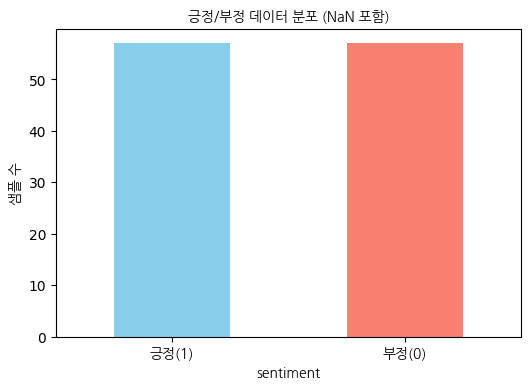

In [ ]:
plt.figure(figsize=(6,4))
label_counts.plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('긍정/부정 데이터 분포 (NaN 포함)', fontproperties=fontprop)
plt.xlabel('sentiment', fontproperties=fontprop)
plt.ylabel('샘플 수', fontproperties=fontprop)
plt.xticks(rotation=0, fontproperties=fontprop)
plt.show()

- 고객 피드백 데이터를 불러와 **간단한 벡터화 방법**을 적용합니다.
    - 전통 방식: **단어 빈도(TF)** 또는 **TF-IDF**로 표현
    - LLM 방식: **사전 제공 Embedding API**를 사용하여 문장을 벡터화

In [ ]:
# 전통 방식 TF-IDF로 표현
from sklearn.feature_extraction.text import TfidfVectorizer

# TF-IDF 계산
tfidf_vectorizer = TfidfVectorizer()
X_tfidf = tfidf_vectorizer.fit_transform(df['feedback'])

print("TF-IDF 결과 shape:", X_tfidf.shape)

TF-IDF 결과 shape: (114, 95)


In [ ]:
# LLM 방식: 사전 제공 Embedding API를 사용
embeddings = []
for text in df['feedback']:
    response = client.embeddings.create(
        model="text-embedding-3-small",
        input=text
    )
    embeddings.append(response.data[0].embedding)

df_embed = pd.DataFrame(embeddings)
print("Embedding 벡터 shape:", df_embed.shape)

Embedding 벡터 shape: (114, 1536)


- **형태소 분석기**로 문장을 토큰화하고 **불용어를 제거**하여 데이터를 정제합니다.
    - 예: KoNLPy Okt를 활용한 명사 추출 및 정제

In [ ]:
from konlpy.tag import Okt

okt = Okt()
tokenized_list = []

for sentence in df['feedback']:
    # 명사만 추출
    nouns = okt.nouns(sentence)
    tokenized_list.append(nouns)

print(tokenized_list)

[['제품', '질'], ['연락처'], ['배송'], ['상품', '손상'], ['가격', '대비'], ['주문', '색상'], ['다음', '또', '이용'], ['상품', '설명'], ['서비스'], ['배송', '기사', '태도', '불만'], ['제품', '마음'], ['사이트'], ['고객', '서비스', '최고'], ['상품'], ['가격'], ['불량품', '배송'], ['반품', '처리'], ['상품', '정보'], ['상품', '포장', '상태'], ['배송', '상태', '안'], ['고객', '센터', '상담'], ['주문', '취소', '안'], ['상품', '후기', '도움'], ['물건', '고장'], ['의사'], ['환불', '처리'], ['서비스', '감동'], ['상품', '사진'], ['무료', '배송'], ['가격'], ['다음', '또', '이용'], ['상품', '설명'], ['포장', '상태'], ['배송', '정보', '부'], ['제품', '기대', '이상'], ['제품', '고장'], ['상품'], ['배송'], ['상품', '품질'], ['상품', '온', '것'], ['배송'], ['구매', '후', '후회'], ['배송', '감사'], ['제품', '손상'], ['상품', '아주', '마음'], ['상품'], ['고객', '서비스', '최고'], ['상품'], ['가격'], ['상품', '불량품', '요'], ['반품', '처리'], ['제품', '정보'], ['상품', '포장', '상태'], ['배송', '상태', '안'], ['고객', '센터', '상담'], ['주문', '취소', '안'], ['상품', '후기', '도움'], ['제품', '고장'], ['의사'], ['환불', '처리'], ['서비스', '감동'], ['상품', '사진'], ['무료', '배송'], ['가격'], ['다음', '또', '이용'], ['상품', '설명'], ['포장', '상태'], ['배송', '정보', '부'], ['제품

In [ ]:
stopwords = ['제품', '배송', '것', '저', '너무']  # 예시, 필요에 따라 추가

cleaned_list = []
for tokens in tokenized_list:
    cleaned = [word for word in tokens if word not in stopwords]
    cleaned_list.append(cleaned)

print(cleaned_list)

[['질'], ['연락처'], [], ['상품', '손상'], ['가격', '대비'], ['주문', '색상'], ['다음', '또', '이용'], ['상품', '설명'], ['서비스'], ['기사', '태도', '불만'], ['마음'], ['사이트'], ['고객', '서비스', '최고'], ['상품'], ['가격'], ['불량품'], ['반품', '처리'], ['상품', '정보'], ['상품', '포장', '상태'], ['상태', '안'], ['고객', '센터', '상담'], ['주문', '취소', '안'], ['상품', '후기', '도움'], ['물건', '고장'], ['의사'], ['환불', '처리'], ['서비스', '감동'], ['상품', '사진'], ['무료'], ['가격'], ['다음', '또', '이용'], ['상품', '설명'], ['포장', '상태'], ['정보', '부'], ['기대', '이상'], ['고장'], ['상품'], [], ['상품', '품질'], ['상품', '온'], [], ['구매', '후', '후회'], ['감사'], ['손상'], ['상품', '아주', '마음'], ['상품'], ['고객', '서비스', '최고'], ['상품'], ['가격'], ['상품', '불량품', '요'], ['반품', '처리'], ['정보'], ['상품', '포장', '상태'], ['상태', '안'], ['고객', '센터', '상담'], ['주문', '취소', '안'], ['상품', '후기', '도움'], ['고장'], ['의사'], ['환불', '처리'], ['서비스', '감동'], ['상품', '사진'], ['무료'], ['가격'], ['다음', '또', '이용'], ['상품', '설명'], ['포장', '상태'], ['정보', '부'], ['기대', '이상'], ['고장'], ['상품'], [], ['상품', '품질'], ['상품', '온'], [], ['구매', '후', '후회'], ['감사'], ['손상'], ['상품', '아주', '마음'

- 고객 피드백 데이터를 **직관적으로 시각화**하여 패턴을 파악합니다.
    - **워드클라우드 생성**: 전체/긍정/부정 리뷰의 핵심 키워드를 시각적으로 표현
    - **막대 그래프**: 긍정/부정 리뷰별 상위 5개 단어의 빈도수 비교 분석

In [ ]:
from wordcloud import WordCloud
from collections import Counter

df['cleaned_token'] = cleaned_list
# 전체
all_words = [word for tokens in df['cleaned_token'] for word in tokens]
all_counter = Counter(all_words)

# 긍정
pos_words = [word for tokens in df[df['label']==1]['cleaned_token'] for word in tokens]
pos_counter = Counter(pos_words)

# 부정
neg_words = [word for tokens in df[df['label']==0]['cleaned_token'] for word in tokens]
neg_counter = Counter(neg_words)

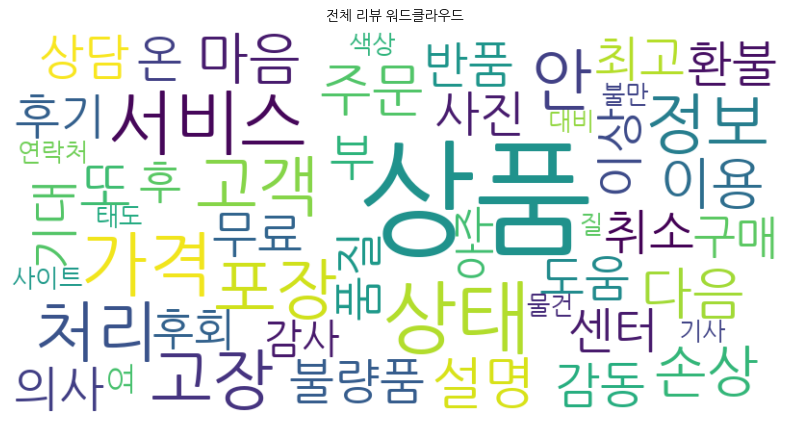

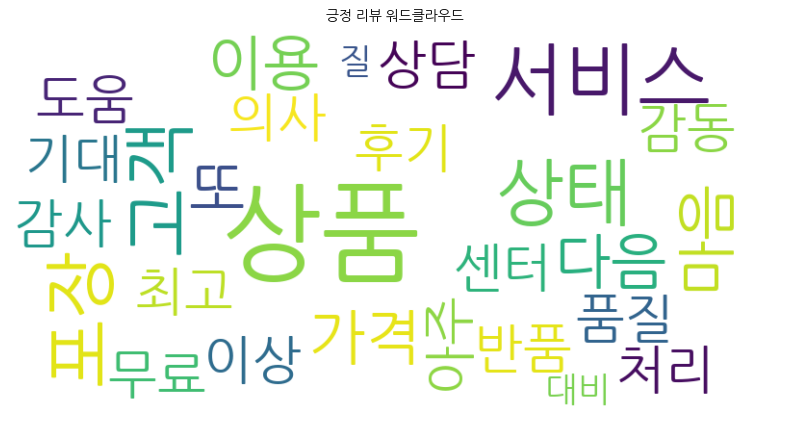

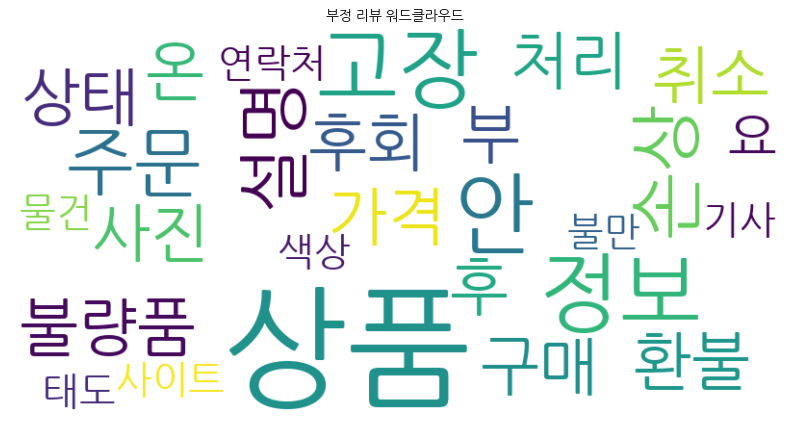

In [ ]:
# 워드클라우드 생성
def plot_wordcloud(counter, title):
    wc = WordCloud(font_path=font_path,
                   background_color='white', width=800, height=400)
    wc.generate_from_frequencies(counter)
    plt.figure(figsize=(10,5))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(title, fontproperties=fontprop)
    plt.show()

plot_wordcloud(all_counter, "전체 리뷰 워드클라우드")
plot_wordcloud(pos_counter, "긍정 리뷰 워드클라우드")
plot_wordcloud(neg_counter, "부정 리뷰 워드클라우드")

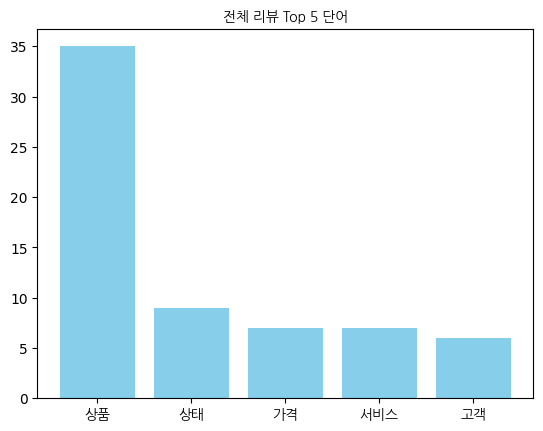

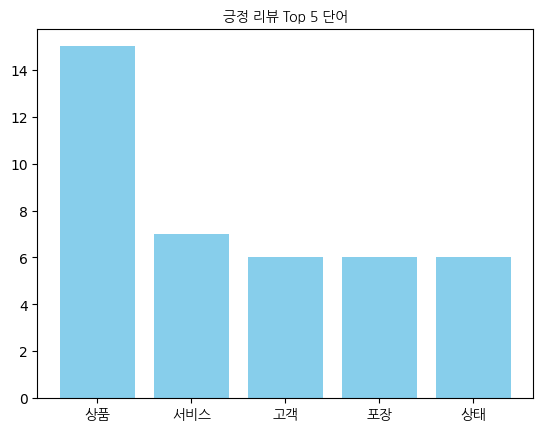

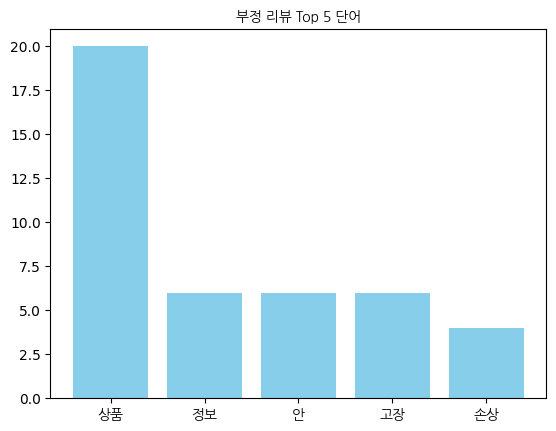

In [ ]:
# 막대 그래프
def plot_top_words(counter, title):
    top5 = counter.most_common(5)
    words, counts = zip(*top5)
    plt.bar(words, counts, color='skyblue')
    plt.title(title, fontproperties=fontprop)
    plt.xticks(rotation=0, fontproperties=fontprop)
    plt.show()

plot_top_words(all_counter, "전체 리뷰 Top 5 단어")
plot_top_words(pos_counter, "긍정 리뷰 Top 5 단어")
plot_top_words(neg_counter, "부정 리뷰 Top 5 단어")

- OpenAI API를 활용하여 단어 빈도 데이터에서 비즈니스 인사이트를 도출합니다.
    - 분석 대상: 전체/긍정/부정 리뷰의 단어 빈도수 데이터
    - 도출 인사이트(필수포함)
        - 고객이 가장 중요하게 생각하는 요소
        - 긍정/부정 리뷰의 차이점
        - 개선이 필요한 부분

In [ ]:
# 전체/긍정/부정 상위 10개 단어
all_top10 = all_counter.most_common(10)
pos_top10 = pos_counter.most_common(10)
neg_top10 = neg_counter.most_common(10)

prompt = f"""
아래는 고객 리뷰의 단어와 빈도 데이터.
데이터를 분석하여 비즈니스 인사이트를 알려줘.

1. 전체 리뷰 단어 빈도 상위 10개: {all_top10}
2. 긍정 리뷰 단어 빈도 상위 10개: {pos_top10}
3. 부정 리뷰 단어 빈도 상위 10개: {neg_top10}

분석 시 다음 내용을 포함해야돼
- 고객이 가장 중요하게 생각하는 요소
- 긍정/부정 리뷰의 차이점
- 개선이 필요한 부분
"""

response = client.chat.completions.create(
    model="gpt-4",
    messages=[
        {"role":"system", "content":"고객 리뷰 데이터를 분석하는 전문가입니다."},
        {"role":"user", "content":prompt}
    ],
    temperature=0.7
)
print("=== AI 인사이트 분석 ===")
print(response.choices[0].message.content)

=== AI 인사이트 분석 ===
분석 결과에 따르면, 고객이 가장 중요하게 생각하는 요소는 '상품'입니다. '상품'이 전체, 긍정, 부정 리뷰 모두에서 가장 높은 빈도로 언급되었습니다. 이는 고객들이 상품의 품질 및 특성에 대해 매우 중요하게 생각하는 것으로 해석될 수 있습니다.

긍정 리뷰와 부정 리뷰의 차이점을 살펴보면, 긍정 리뷰에서는 '서비스', '고객', '포장'이 높은 빈도로 언급되었습니다. 이는 고객 서비스, 고객 경험, 그리고 상품의 포장 상태가 고객 만족도에 큰 영향을 미치는 것으로 해석될 수 있습니다. 반면에, 부정 리뷰에서는 '정보', '안', '고장', '손상', '주문', '설명', '불량품', '취소' 등이 높은 빈도로 언급되었습니다. 이는 상품 정보의 부족, 상품의 고장 및 손상, 주문 및 설명과 관련된 문제, 불량품, 주문 취소 등이 고객 불만의 주요 원인이라는 것을 나타냅니다.

따라서, 개선이 필요한 부분은 다음과 같습니다:

1. 상품 정보 제공: 고객들이 상품 정보를 충분히 이해하지 못하고 있음을 나타내고 있습니다. 상품 정보의 정확성 및 투명성을 높이는 것이 필요합니다.
2. 상품 품질 관리: 고객 리뷰에서 '고장', '손상', '불량품' 등 상품 품질에 대한 문제가 자주 언급되었습니다. 상품의 품질 관리를 강화하고, 고장 및 손상된 상품이 고객에게 전달되지 않도록 하는 것이 중요합니다.
3. 주문 및 취소 절차 개선: 주문 및 취소 절차와 관련된 문제도 고객 불만의 원인으로 보입니다. 주문 및 취소 절차를 더욱 간편하고 명확하게 만드는 것이 필요합니다.
4. 고객 서비스 향상: 긍정 리뷰에서 '서비스', '고객' 등이 높은 빈도로 언급되었으므로, 고객 서비스의 질을 높이는 것이 고객 만족도를 향상시키는 데 중요하다는 것을 의미합니다. 고객 서비스 팀의 교육 및 훈련을 강화하여 고객에게 더 나은 서비스를 제공하는 것이 필요합니다.


- 고객 리뷰 데이터를 대상으로 **형태소 분석 및 전처리**를 수행합니다.
    - 예: KoNLPy의 Okt를 사용한 명사 추출 및 불용어 제거

In [ ]:
# Okt를 사용한 명사 추출 및 불용어 제거
# df["cleaned_token"]에 값이 추가된 상태

- 전처리된 텍스트에 **TF-IDF 벡터화**를 적용하여 문서-단어 행렬을 생성합니다.
    - 예: 최대 20개 특성으로 제한하여 핵심 키워드 추출

In [ ]:
# 문자열로 합치기
docs = [' '.join(tokens) for tokens in df['cleaned_token']]

# 최대 20개 특성으로 제한
vectorizer = TfidfVectorizer(max_features=20)
X_tfidf = vectorizer.fit_transform(docs)
print(X_tfidf.size)

127


- TF-IDF 행렬에서 **IDF 값을 분석**하여 단어의 희귀성과 중요도를 파악합니다.
    - 높은 IDF: 특정 리뷰에만 나타나는 특별한 문제
    - 낮은 IDF: 대부분 리뷰에 공통적으로 나타나는 일반적 문제

In [ ]:
# 단어별 IDF 확인
idf_scores = dict(zip(vectorizer.get_feature_names_out(), vectorizer.idf_))
sorted_idf = sorted(idf_scores.items(), key=lambda x: x[1], reverse=True)

print("IDF 높은 단어 TOP 5 (특별한 문제)")
for word, score in sorted_idf[:5]:
    print(f"{word}: {score.round(2)}점")
print("IDF 낮은 단어 TOP 5 (공통적 문제)")
for word, score in sorted_idf[-5:]:
    print(f"{word}: {score.round(2)}점")

IDF 높은 단어 TOP 5 (특별한 문제)
기대: 4.36점
반품: 4.36점
아주: 4.36점
의사: 4.36점
이상: 4.36점
IDF 낮은 단어 TOP 5 (공통적 문제)
포장: 3.8점
가격: 3.67점
서비스: 3.67점
상태: 3.44점
상품: 2.16점


- IDF 분석 결과를 **OpenAI GPT API**에 전달하여 인사이트를 도출합니다.
    - **프롬프트 필수포함**:  공통 문제점, 특별 이슈, 개선 우선순위 3가지 제거

In [ ]:
prompt = f"""
고객 리뷰 데이터를 TF-IDF로 분석한 결과.

단어 IDF 값 높은 5개: {sorted_idf[:5]}
단어 IDF 값 낮으 5개: {sorted_idf[-5:]}

분석중에 이 3가지를 제거해줘
1. 공통 문제점
2. 특별 이슈
3. 개선 우선순위

내가 작성해준 내용을 비즈니스 인사이트를 정리해.
"""

response = client.chat.completions.create(
    model="gpt-4",
    messages=[
        {"role":"system", "content":"고객 리뷰 데이터를 분석하는 전문가입니다."},
        {"role":"user", "content":prompt}
    ],
    temperature=0.7
)
print("=== AI 인사이트 분석 ===")
print(response.choices[0].message.content)

=== AI 인사이트 분석 ===
분석 결과를 바탕으로 다음과 같이 비즈니스 인사이트를 도출하였습니다.

1. 고객들의 기대치가 높은 것으로 보입니다. '기대'라는 단어의 IDF 값이 높은 것은 그만큼 이 단어가 고객 리뷰에서 자주 등장하지 않았다는 의미이므로, 고객들이 상품이나 서비스에 대해 높은 기대치를 가지고 있다는 것을 암시합니다. 이를 통해 우리는 고객들의 기대치를 충족시키기 위해 더 노력해야 함을 확인하였습니다.

2. '반품', '의사', '이상' 등의 단어도 IDF 값이 높게 나타났습니다. 이는 고객들이 상품의 품질에 대해 불만을 가지고 있거나, 상품을 반환하고자 하는 의사가 있음을 나타낼 수 있습니다. 이를 통해 우리는 제품 품질 개선과 반품 처리 절차의 개선이 필요함을 인지하였습니다.

3. 반면에, '포장', '가격', '서비스', '상태', '상품' 등의 단어는 IDF 값이 상대적으로 낮습니다. 이는 이러한 주제가 고객 리뷰에서 자주 언급되었다는 것을 의미하며, 이는 고객들이 이러한 측면에 중요한 가치를 두고 있다는 것을 의미합니다. 따라서 이러한 측면의 개선은 고객 만족도를 높이는 데 중요할 것입니다.

제거해야 할 요소들로는 공통 문제점, 특별 이슈, 개선 우선순위가 있습니다. 이를 통해 고객 리뷰를 보다 명확하게 이해하고 비즈니스 전략을 세우는 데 도움이 될 것입니다.


In [ ]:
#프롬프트 작성할때 3가지를 제거하는게 맞죠??

고객 서비스팀에서 매일 수백 건의 고객 피드백을 받고 있지만, 수동으로 분석하기에는 시간과 인력이 부족합니다. AI를 활용하여 고객 피드백을 자동으로 분석하는 시스템을 구축하려고 합니다.

- LLM을 활용하여 **부정 리뷰를 집중 분석**하는 프롬프트를 개발합니다:
    - **문제점 파악**: 고객 불만족 요소 3가지 추출
    - **핵심 이슈**: 가장 심각한 문제점 도출
    - **개선방안 제시**: 문제 해결을 위한 구체적 방안
- **프롬프트 테스트:** 세 가지 프롬프트 기법으로 부정 리뷰를 분석합니다:
    - **Zero-shot**: 예시 없이 불만 요소 직접 추출
    - **Few-shot**: 부정 리뷰 예시로 학습 후 분석
    - **Persona**: 고객 불만 처리 전문가 관점에서 심층 분석

In [ ]:
# 부정 리뷰만 추출
neg_reviews = df[df['label']==0]['feedback'].tolist()
neg_text = "\n".join(neg_reviews)

In [ ]:
prompt_zero = f"""
부정 리뷰들을 직접 추출해서 나온 데이터를 분석해줘 그리고
1. 문제점 파악: 고객 불만족 요소 3가지 추출
2. 핵심 이슈: 가장 심각한 문제점 도출
3. 개선방안 제시: 문제 해결을 위한 구체적 방안
형식에 맞춰 정리해줘
"""

response_zero = client.chat.completions.create(
    model="gpt-4",
    messages=[
        {"role":"system","content":"너는 고객 불가 데이터를 수집해서 분석하는 직원이야"},
        {"role":"user","content":prompt_zero}
    ],
    temperature=0.7
)
print("=== [5] 부정 리뷰 분석 프롬프트 ==")
print("Zero-shot:")
print(response_zero.choices[0].message.content)

=== [5] 부정 리뷰 분석 프롬프트 ==
Zero-shot:
알겠습니다, 부정 리뷰 데이터를 분석한 결과를 다음과 같이 정리해보겠습니다.

1. 문제점 파악:
    - 제품 품질: 고객들이 제품의 품질에 대해 불만을 가지고 있는 것을 확인하였습니다. 제품의 내구성이나 기능적 측면에서 문제를 제기하였습니다.
    - 배송: 배송과 관련하여 상품의 배송이 늦어지거나, 상품이 손상된 상태로 도착하는 등의 문제가 있었습니다.
    - 고객 서비스: 고객 서비스에 대한 불만이 있었습니다. 고객 서비스의 응대 품질이나 처리 속도에 문제가 있다는 의견이 있었습니다.

2. 핵심 이슈:
    - 가장 심각한 문제점은 '제품 품질'입니다. 고객 리뷰에 따르면, 제품의 품질이 가장 큰 불만족 요소로 지적되었으며, 이로 인해 고객들의 재구매 의사가 줄어들고 브랜드 이미지가 하락하는 결과를 초래하고 있습니다.

3. 개선방안 제시:
    - 제품 품질 개선: 제품의 품질을 개선하기 위해 제품 개발 및 품질 관리 과정을 강화해야 합니다. 특히, 고객들이 자주 언급한 결함 부분을 중심으로 개선 작업을 진행해야 합니다.
    - 배송 프로세스 개선: 배송업체와의 협력을 강화하거나, 패키지 방식을 개선하여 제품이 손상되지 않게 해야합니다. 또한, 배송 진행 상황을 고객에게 정확하게 알려주는 시스템을 도입해 고객의 불안감을 줄일 수 있습니다.
    - 고객 서비스 개선: 고객 서비스 직원의 교육을 강화하고, 고객의 문의사항이나 불만사항을 빠르게 처리할 수 있는 시스템을 구축해야 합니다. 이를 통해 고객의 만족도를 높일 수 있을 것입니다.


In [ ]:
prompt_few_shot = f"""
다음 부정 리뷰 데이터를 분석하여:
1. 문제점 파악: 고객 불만족 요소 3가지 추출
2. 핵심 이슈: 가장 심각한 문제점 도출
3. 개선방안 제시: 문제 해결을 위한 구체적 방안
형식에 맞춰 정리해줘

여기 부정 리뷰가 있으니까 형식에 맞춰 정리해줘:
{neg_text}
"""

response_few_shot = client.chat.completions.create(
    model="gpt-4",
    messages=[
        {"role":"system","content":"너는 고객 불가 데이터를 수집해서 분석하는 직원이야"},
        {"role":"user","content":prompt_few_shot}
    ],
    temperature=0.7
)
print("Few-shot:")
print(response_few_shot.choices[0].message.content)

Few-shot:
1. 문제점 파악: 
   - 배송 문제: 배송이 늦거나, 배송 정보가 부정확하거나, 배송 상태가 안 좋거나, 배송된 상품이 손상되거나 불량품이었음
   - 제품 문제: 상품이 손상되었거나, 불량품이었거나, 주문한 상품과 다르거나, 제품 정보가 잘못되어 있음
   - 고객 서비스 문제: 연락처 불친절, 느린 환불 처리, 주문 취소 불가, 상품 설명 불친절, 사이트가 느림

2. 핵심 이슈: 
   - 배송 문제가 가장 심각해 보임. 배송이 늦는 것은 고객의 불만을 가장 크게 일으키며, 부정확한 배송 정보, 나쁜 배송 상태, 손상된 또는 불량품 배송은 고객의 신뢰를 크게 훼손시키는 요소임

3. 개선방안 제시: 
   - 배송 문제: 배송 프로세스를 개선하고, 배송 정보의 정확성을 높이는 방안을 강구해야 함. 또한, 배송 상태를 보장하는 방안을 마련하고, 손상되거나 불량품이 배송되지 않도록 품질 관리를 강화해야 함.
   - 제품 문제: 제품의 품질 관리를 강화하고, 제품 정보의 정확성을 높이는 방안을 마련해야 함. 고객이 주문한 제품이 정확하게 배송되도록 주문 처리 프로세스를 개선해야 함.
   - 고객 서비스 문제: 고객 서비스 품질을 개선하고, 환불 처리 시스템을 개선하고, 주문 취소 프로세스를 개선해야 함. 또한, 상품 설명의 친절성을 높이는 방안을 마련하고, 사이트의 속도를 개선해야 함.


In [ ]:
prompt_persona = f"""
다음 부정 리뷰 데이터를 분석하여:
1. 문제점 파악: 고객 불만족 요소 3가지 추출
2. 핵심 이슈: 가장 심각한 문제점 도출
3. 개선방안 제시: 문제 해결을 위한 구체적 방안
형식에 맞춰 정리해줘

여기 부정 리뷰가 있으니까 형식에 맞춰 정리해줘:
{neg_text}
"""

response_persona = client.chat.completions.create(
    model="gpt-4",
    messages=[
        {"role":"system","content":"너는 고객 불만 처리 전문가야, 저번에 너의 아이디어로 고객들 문제를 파악해서 모두 해결했잖아 이번에도 해보자!"},
        {"role":"user","content":prompt_persona}
    ],
    temperature=0.7
)
print("persona:")
print(response_persona.choices[0].message.content)

persona:
1. 문제점 파악: 고객 불만족 요소 3가지 추출
   - 제품 문제: 상품이 손상되서 오거나, 주문한 색상이 아닌 제품이 배송되는 등 제품과 관련된 문제가 많이 제기되었습니다.
   - 배송 문제: 배송이 늦어지거나, 배송 상태가 안 좋은 경우, 배송 정보가 부정확한 경우 등 배송과 관련된 문제가 빈번히 발생하였습니다.
   - 서비스 문제: 불친절한 고객서비스, 느린 사이트 속도, 느린 환불 처리 등 서비스 부분에서 많은 불만이 제기되었습니다.

2. 핵심 이슈: 가장 심각한 문제점 도출
   - 제품 문제와 배송 문제가 가장 큰 이슈로 보입니다. 고객들이 제품을 주문하는 주된 목적은 제품을 원활하게 받기 위함이므로, 이 부분에서 문제가 발생한다면 고객 만족도를 크게 떨어뜨릴 수 있습니다.

3. 개선방안 제시: 문제 해결을 위한 구체적 방안
   - 제품 문제: 제품의 품질 관리를 강화하고, 제품 정보를 정확하게 제공함으로써 고객이 원하는 제품을 받을 수 있도록 해야 합니다. 또한, 제품이 손상되지 않도록 포장을 강화할 필요가 있습니다.
   - 배송 문제: 배송 과정을 투명하게 공개하고, 배송 기간을 최대한 단축시켜 고객이 빠르게 제품을 받을 수 있도록 개선해야 합니다. 또한, 배송 상태가 좋지 않은 경우는 배송업체와 협의하여 개선해야 합니다.
   - 서비스 문제: 고객 서비스 직원의 교육을 강화하여 고객에게 더 친절하고 빠른 서비스를 제공해야 합니다. 또한, 사이트 속도와 환불 처리 속도를 개선하기 위해 시스템을 업그레이드해야 합니다.
